In [26]:
import math
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.crs as crs
import cartopy.feature as cfeature
import h5py  
from astropy.time import Time
import os
import glob
from osgeo import gdal
import scipy.ndimage
import rasterio as rio
import re
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
from pyhdf.SD import SD, SDC
import pprint
import matplotlib.colors as colors 
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import csv
import pprint
import matplotlib.colors as colors 
from mpl_toolkits.axes_grid1 import make_axes_locatable 

In [3]:
# Set input directory, and change working directory - plug in D:
inDir = "D:\\masters_data\\ATL08"   # I should change this so I can work from github?
os.chdir(inDir)                                                               # Change to working directory
outDir = os.path.normpath(os.path.split(inDir)[0] + os.sep + 'output') + '\\' # Create and set output directory
if not os.path.exists(outDir): os.makedirs(outDir)

In [4]:
# select first MODIS file
ATL08Files = glob.glob('*ATL08*')
print(len(ATL08Files))
print(ATL08Files[0])

442
ATL08_20190101101716_00610201_003_01.h5


In [5]:
# work with just one file first
ATL08 = h5py.File(ATL08Files[0], 'r')

In [6]:
ATL08_mean_canopy = ATL08['/gt2l/land_segments/canopy/h_mean_canopy'][:]
ATL08_min_canopy = ATL08['/gt2l/land_segments/canopy/h_min_canopy'][:]
ATL08_max_canopy = ATL08['/gt2l/land_segments/canopy/h_max_canopy'][:]
ATL08_toc_roughness = ATL08['/gt2l/land_segments/canopy/toc_roughness'][:]
ATL08_canopy_openness = ATL08['/gt2l/land_segments/canopy/canopy_openness'][:]

ATL08_latitude = ATL08['/gt2l/land_segments/latitude'] [:]
ATL08_longitude = ATL08['/gt2l/land_segments/longitude'][:]
ATL08_dt = ATL08['/gt2l/land_segments/delta_time'][:]
ATL08_segment_id_beg = ATL08['/gt2l/land_segments/segment_id_beg'][:]
ATL08_segment_id_end = ATL08['/gt2l/land_segments/segment_id_end'][:]
ATL08_canopy_rh_conf = ATL08['/gt2l/land_segments/canopy/canopy_rh_conf'][:]
ATL08_ph_segment_id = ATL08['/gt2l/signal_photons/ph_segment_id'][:]

In [7]:
# constants for conversion lat lon -> tile H,V and r,c
R = 6371007.181	    # the radius of the idealizes sphere representing the Earth
T = 1111950	        # the height and width of each MODIS tile in the projection plane
Xmin = -20015109    # the western limit of the projection plane
Ymax = 10007555	    # the northern limit of the projection plane
w = T/2400.0	    # the actual size of a '500m' MODIS sinusoidal grid cell. (would be /1200 for a 1km grid)

# equations
lat = ATL08_latitude[0]
lon = ATL08_longitude[0]
phi = lat/(180/math.pi) # convert to radians
lamb = lon/(180/math.pi)
x = R*lamb*math.cos(phi)
y = R*phi
H = math.floor((x-Xmin)/T) # Horizontal tile number H
V = math.floor((Ymax-y)/T) # Vertical tile number V
r = int(math.floor(((Ymax-y)%T)/w-0.5))
c = int(math.floor(((x-Xmin)%T)/w-0.5))

In [8]:
print(lat)
print(lon)
print()
print("Tile: \t\t H{}V{}".format(H, V))
print("Row: \t\t {}".format(r))
print("Column: \t {}".format(c))
print(ATL08_latitude[0])

0.1344654
22.70255

Tile: 		 H20V8
Row: 		 2367
Column: 	 648
0.1344654


In [9]:
# shows all ATL08 files naming convention made easier to read
number = 0
for i in ATL08Files:
    productId1 = ATL08Files[number].split('_')[0]                                         
    yeardoy = ATL08Files[number].split(productId1 + '_')[1].split('.')[0]                 
    date = yeardoy[6:8] + "/" + yeardoy[4:6] + "/" + yeardoy[0:4]
    # hour-minute-second
    hhmmss = yeardoy[8:10] + "-" + yeardoy[10:12] + "-" + yeardoy[12:14]
    ground_track = yeardoy[15:19]
    cycle_number = yeardoy[19:21]
    segment_number = yeardoy[21:23]

#     print("ID: {}      date: {}      ground_track:{}      cycle_number: {}    segment number: {}     "
#          "hhmmss: {}".format(productId1, date, ground_track, cycle_number, segment_number, hhmmss))
    number +=1


In [10]:
number = 0
for i in ATL08_latitude: 
    str('%.2d' %H) + str('%.2d' %V)
    pixels = ('H' + str('%.2d' %H) + 'V' + str('%.2d' %V))
    if pixels != "H20V08":
        print(pixels)
    else:
        number +=1

print("{0} out of {1} are pixels from H20V08 tile".format(number, len(ATL08_latitude)))

21071 out of 21071 are pixels from H20V08 tile


now I want row / column list

In [11]:
r_list = []
c_list = []
number = 0

for i in ATL08_latitude:
    lat = ATL08_latitude[number]
    lon = ATL08_longitude[number]
    phi = lat/(180/math.pi) # convert to radians
    lamb = lon/(180/math.pi)
    x = R*lamb*math.cos(phi)
    y = R*phi
    r = int(math.floor(((Ymax-y)%T)/w-0.5))
    c = int(math.floor(((x-Xmin)%T)/w-0.5))
    
    r_list.append(r)
    c_list.append(c)
    number += 1

In [12]:
canopy_height_array = np.zeros((2400,2400)) 

In [13]:
ATL08_mean_canopy

array([3.3834064e+01, 3.9203651e+01, 5.1422920e+01, ..., 3.4028235e+38,
       3.4028235e+38, 3.4028235e+38], dtype=float32)

In [14]:
for i in range(len(ATL08_mean_canopy)):
    row = r_list[i]
    col = c_list[i]
    canopy_h = ATL08_mean_canopy[i]
    canopy_height_array[row, col] = canopy_h

In [15]:
canopy_height_array[canopy_height_array == 0] = np.nan

In [17]:
np.savetxt("D:\\masters_data\\output\\csv\\canopy_height_array.csv", canopy_height_array, delimiter=",")

bring in fire frequency for the H20V08 tile

In [18]:
First_BA = pd.read_csv("D:\\masters_data\\output\\first_BA.csv")
Second_BA = pd.read_csv("D:\\masters_data\\output\\second_BA.csv")

In [19]:
First_LF =  np.zeros((2400, 2400))
First_LF[First_LF == 0] = np.nan

First_MLF =  np.zeros((2400, 2400))
First_MLF[First_MLF == 0] = np.nan

First_MHF =  np.zeros((2400, 2400))
First_MHF[First_MHF == 0] = np.nan

First_HF =  np.zeros((2400, 2400))
First_HF[First_HF == 0] = np.nan

In [20]:
First_LF_result = np.where(First_BA == 0)
First_LF[First_LF_result] = canopy_height_array[First_LF_result]

First_MLF_result = np.where((First_BA > 0) & (First_BA < 3))
First_MLF[First_MLF_result] = canopy_height_array[First_MLF_result]

First_MHF_result = np.where((First_BA > 2) & (First_BA < 10))
First_MHF[First_MHF_result] = canopy_height_array[First_MHF_result]

First_HF_result = np.where(First_BA > 10)
First_HF[First_HF_result] = canopy_height_array[First_HF_result]

In [21]:
Second_LF =  np.zeros((2400, 2400))
Second_LF[Second_LF == 0] = np.nan

Second_MLF =  np.zeros((2400, 2400))
Second_MLF[Second_MLF == 0] = np.nan

Second_MHF =  np.zeros((2400, 2400))
Second_MHF[Second_MHF == 0] = np.nan

Second_HF =  np.zeros((2400, 2400))
Second_HF[Second_HF == 0] = np.nan

In [22]:
Second_LF_result = np.where(Second_BA == 0)
Second_LF[Second_LF_result] = canopy_height_array[Second_LF_result]

Second_MLF_result = np.where((Second_BA > 0) & (Second_BA < 3))
Second_MLF[Second_MLF_result] = canopy_height_array[Second_MLF_result]

Second_MHF_result = np.where((Second_BA > 2) & (Second_BA < 10))
Second_MHF[Second_MHF_result] = canopy_height_array[Second_MHF_result]

Second_HF_result = np.where(Second_BA > 10)
Second_HF[Second_HF_result] = canopy_height_array[Second_HF_result]

In [24]:
print("Mean of LF : {} ".format(np.nanmean(First_LF)))
print("Mean of MLF : {} ".format(np.nanmean(First_MLF)))
print("Mean of MHF : {} ".format(np.nanmean(First_MHF)))
print("Mean of HF : {} ".format(np.nanmean(First_HF)))

print()

print("Mean of LF : {} ".format(np.nanmean(Second_LF)))
print("Mean of MLF : {} ".format(np.nanmean(Second_MLF)))
print("Mean of MHF : {} ".format(np.nanmean(Second_MHF)))
print("Mean of HF : {} ".format(np.nanmean(Second_HF)))

Mean of LF : 2.7640420763598922e+38 
Mean of MLF : 3.0247319701202565e+38 
Mean of MHF : 2.6031816811810828e+38 
Mean of HF : 3.4028234663852886e+38 

Mean of LF : 2.6917857271406014e+38 
Mean of MLF : 3.0778127095268547e+38 
Mean of MHF : 2.9621424994547613e+38 
Mean of HF : 2.46411354462383e+38 


Not quite sure what the units of measure is for this. Also I need a way to for loop through all HDF files in this section

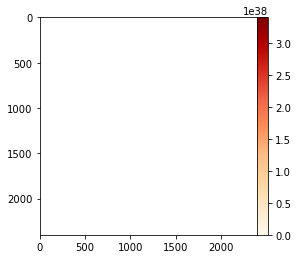

In [29]:
# ignore - for some reason need this to run to make the next one work - sign of poor script!
u = np.unique(First_LF) 
bounds = np.concatenate(([First_LF.min()], 
                         u[:-1]+np.diff(u)/2., 
                         [First_LF.max()]))
    
fig, axes = plt.subplots() 
img = axes.imshow(First_LF, cmap = "OrRd", 
                  ) 
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %") 
  
color_bar = plt.colorbar(img,  
                        cax = cax) 

plt.show()

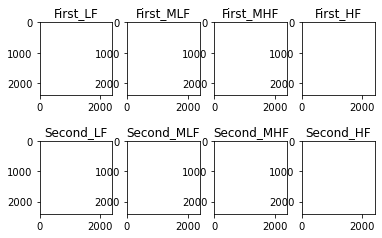

In [30]:
# First_LF
plt.subplot(2,4,1)
color_map = plt.imshow(First_LF)
plt.title("First_LF")
img = axes.imshow(First_LF, vmin = 0, cmap = "PiYG")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Set2")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")


# First_MLF
plt.subplot(2,4,2)
color_map = plt.imshow(First_MLF)
plt.title("First_MLF")
img = axes.imshow(First_MLF, vmin = 0, cmap = "PiYG")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Set2")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")


# First_MHF
plt.subplot(2,4,3)
color_map = plt.imshow(First_MHF)
plt.title("First_MHF")
img = axes.imshow(First_MHF, vmin = 0, cmap = "PiYG")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Set2")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")


# First_HF
plt.subplot(2,4,4)
color_map = plt.imshow(First_HF)
plt.title("First_HF")
img = axes.imshow(First_HF, vmin = 0, cmap = "PiYG")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Set2")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")


# Second_LF
plt.subplot(2,4,5)
color_map = plt.imshow(Second_LF)
plt.title("Second_LF")
img = axes.imshow(Second_LF, vmin = 0, cmap = "PiYG")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Set2")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")


# Second_MLF
plt.subplot(2,4,6)
color_map = plt.imshow(Second_MLF)
plt.title("Second_MLF")
img = axes.imshow(Second_MLF, vmin = 0, cmap = "PiYG")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Set2")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")


# Second_MHF
plt.subplot(2,4,7)
color_map = plt.imshow(Second_MHF)
plt.title("Second_MHF")
img = axes.imshow(Second_MHF, vmin = 0, cmap = "PiYG")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Set2")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")


# Second_HF
plt.subplot(2,4,8)
color_map = plt.imshow(Second_HF)
plt.title("Second_HF")
img = axes.imshow(Second_HF, vmin = 0, cmap = "PiYG")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Set2")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

Hmmm - probs should try and for loop it - probably just have almost no points - have a look in a csv file

In [34]:
np.savetxt("C:\\Users\\samgr\\OneDrive\\Desktop\\First_LF.csv", First_LF, delimiter=",")

So, it does work but its just a very thin line - so next stage is to try and for loop through all the ATL08 files 